<a href="https://colab.research.google.com/github/aasem/cvision2025/blob/main/k_nearest_neighbour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## k-Nearest Neighbour Classifier for CIFAR10 Dataset
**Preliminary Stuff - Definitions, Data Access and Visualization**


In [1]:
# Definitions
import numpy as np
import matplotlib.pyplot as plt
!git clone https://github.com/aasem/cvision2025
# Definitions
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/cvision2025')
from cvision2025 import data_utils
from cvision2025 import download
%matplotlib inline

Cloning into 'cvision2025'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 58 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 2.61 MiB | 12.16 MiB/s, done.
Resolving deltas: 100% (11/11), done.


**kNN Classifier Definition**

In [2]:
class KNearestNeighbor(object):
    def __init__(self):
        pass
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        dists = np.sqrt(np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T))
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:k]])
            pass
            y_pred[i]= (np.argmax(np.bincount(closest_y)))
            pass
        return y_pred

**Downloading the Dataset**

In [3]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download.maybe_download_and_extract(url,download_dir)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


**Converting Raw Files into Training and Test Datasets**

In [4]:
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


**Examining the Samples**

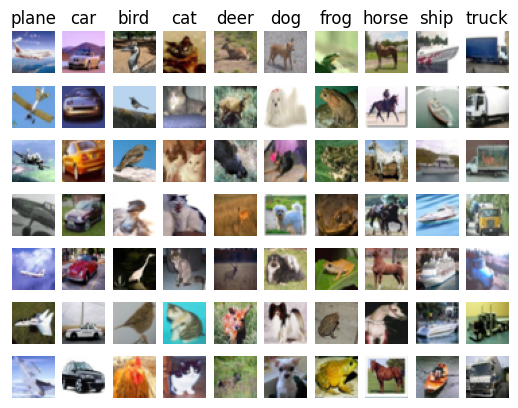

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

**Subsampling the Data**

In [6]:
# To avoid memory crash
num_training = 10000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 1000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [7]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(10000, 3072) (1000, 3072)


**Perform kNN Classification**

In [8]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists= classifier.compute_distances(X_test)
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 296 / 1000 correct => accuracy: 0.296000


**Attempt at Cross Validating (5-Fold)**

In [9]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
k_to_accuracies = {}



for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0,num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds

        temp = np.delete(X_train,num_knn,0)
        X_train = np.concatenate((temp),axis = 0)
        y_train = np.delete(y_train,num_knn,0)
        y_train = np.concatenate((y_train),axis = 0)

        classifier = KNearestNeighbor()
        classifier.train(X_train, y_train)
        dists = classifier.compute_distances(X_test)
        y_test_pred = classifier.predict_labels(dists, k)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / num_test
#         print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[k].append(accuracy)


print("Printing our 5-fold accuracies for varying values of k:")
print()
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

Printing our 5-fold accuracies for varying values of k:

k = 1, accuracy = 0.577000
k = 1, accuracy = 0.568000
k = 1, accuracy = 0.565000
k = 1, accuracy = 0.549000
k = 1, accuracy = 0.554000
k = 3, accuracy = 0.575000
k = 3, accuracy = 0.548000
k = 3, accuracy = 0.557000
k = 3, accuracy = 0.535000
k = 3, accuracy = 0.531000
k = 5, accuracy = 0.589000
k = 5, accuracy = 0.568000
k = 5, accuracy = 0.595000
k = 5, accuracy = 0.550000
k = 5, accuracy = 0.557000
k = 8, accuracy = 0.597000
k = 8, accuracy = 0.592000
k = 8, accuracy = 0.568000
k = 8, accuracy = 0.548000
k = 8, accuracy = 0.572000
k = 10, accuracy = 0.605000
k = 10, accuracy = 0.574000
k = 10, accuracy = 0.568000
k = 10, accuracy = 0.532000
k = 10, accuracy = 0.570000
k = 12, accuracy = 0.609000
k = 12, accuracy = 0.587000
k = 12, accuracy = 0.571000
k = 12, accuracy = 0.530000
k = 12, accuracy = 0.551000
k = 15, accuracy = 0.588000
k = 15, accuracy = 0.594000
k = 15, accuracy = 0.550000
k = 15, accuracy = 0.548000
k = 15, acc

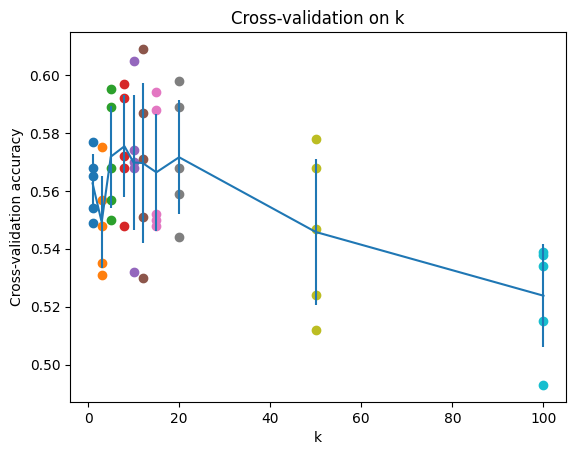

In [10]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

**Final Results with Best Value of k**

In [11]:
# Choosing best value of k based on cross-validation results

best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Computing and displaying the accuracy for best k found during cross-validation
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 570 / 1000 correct => accuracy: 0.570000


**Implementing kNN from Scikit Learn Library**

In [12]:
# instantiating the classifier
from sklearn.neighbors import KNeighborsClassifier
kNN = KNeighborsClassifier(n_neighbors=10, metric='euclidean')

In [13]:
# training the model by feeding it the whole training dataset
kNN.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=10)

In [14]:
# predict the class labels for the test dataset
y_test_pred_kNN = kNN.predict(X_test)

In [15]:
# Computing and displaying the accuracy for best k found during cross-validation
num_correct_kNN = np.sum(y_test_pred_kNN == y_test)
accuracy_kNN = float(num_correct_kNN) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct_kNN, num_test, accuracy_kNN))

Got 570 / 1000 correct => accuracy: 0.570000
